In [1]:
!pip install PyDrive
import os
import json
import datetime, time
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1cZ4NMEAMD0Kd64wnv9epbnofDipFrNRd'})
download.GetContentFile('ECE219_tweet_data.zip')

In [0]:
download = drive.CreateFile({'id': '1RvxD3Yx76NWqm5QAg_0gIwUt2foQu8T3'})
download.GetContentFile('ECE219_tweet_test.zip')

In [5]:
!unzip ECE219_tweet_data.zip

Archive:  ECE219_tweet_data.zip
  inflating: tweets_#nfl.txt         
  inflating: tweets_#superbowl.txt   
  inflating: tweets_#sb49.txt        
  inflating: tweets_#patriots.txt    
  inflating: tweets_#gohawks.txt     
  inflating: tweets_#gopatriots.txt  


In [6]:
!unzip ECE219_tweet_test.zip

Archive:  ECE219_tweet_test.zip
  inflating: sample2_period1.txt     
  inflating: sample2_period3.txt     
  inflating: sample2_period2.txt     
  inflating: sample1_period2.txt     
  inflating: sample1_period3.txt     
  inflating: sample1_period1.txt     
  inflating: sample0_period1.txt     
  inflating: sample0_period3.txt     
  inflating: sample0_period2.txt     


In [0]:
import numpy as np 
np.random.seed(42) 
import random 
random.seed(42)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [18]:
path = "./"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]
test_files_1 =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt"]
test_files_2 =["sample1_period1.txt","sample1_period2.txt","sample1_period3.txt"]
test_files_3 =["sample2_period1.txt","sample2_period2.txt","sample2_period3.txt"]
test_files = [test_files_1,test_files_2,test_files_3]
for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)


files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [0]:
def transfer_time(data_raw,time_type):
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','mentioned','media','active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)                             
        pddata_raw['time'] = hour_accu
    elif time_type == 'minute':
        minu_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day-14)*24 + (p.hour-0))*12 + p.minute//5)             
        pddata_raw['time'] = minu_accu    
    else:
        print("Invalid time type")
        
    return pddata_raw

In [0]:
def six_times_window(df,df_y):
    a = df.values.tolist()
    b = []
    for i in range(len(a)-5):
        tmp = []
        for j in range(i,i+6):
            tmp += a[j]
        b.append(tmp)    
    return pd.DataFrame(b),df_y[5:]

In [0]:
def generate_df(pddata_raw):
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max','mentioned','media','active','author','favourites_count','title'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))

    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [0]:
def parse_dataset(path,files):
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r') :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']             
            ment = len(a['tweet']['entities']['user_mentions'])        
            medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
            hist_tw = a['tweet']['user']["statuses_count"]
            hist_yr = a['tweet']['user']['created_at'][-4:]
            acti = hist_tw/(2015-float(hist_yr)+1) 
            auth = a['author']['name']
            favo = a['tweet']['user']['favourites_count']
            titl = len(a['title'])

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)    
            row_tmp.append(ment) 
            row_tmp.append(medi) 
            row_tmp.append(acti)  
            row_tmp.append(auth)
            row_tmp.append(favo)
            row_tmp.append(titl)

            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
    pddata_raw_2['time'] = pddata_raw_2['time'] - pddata_raw_2.loc[0,'time']

    pddata_raw_3 = transfer_time(data_raw[2],'hour')  
    pddata_raw_3['time'] = pddata_raw_3['time'] - pddata_raw_3.loc[0,'time']
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

In [0]:
def parse_testdata(path,file,time_type):
    # extract raw features
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        tweet = 1        
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']             
        ment = len(a['tweet']['entities']['user_mentions'])        
        medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
        hist_tw = a['tweet']['user']["statuses_count"]
        hist_yr = a['tweet']['user']['created_at'][-4:]
        acti = hist_tw/(2015-float(hist_yr)+1) 
        auth = a['author']['name']
        favo = a['tweet']['user']['favourites_count']
        titl = len(a['title'])
        
        # append to list
        row_tmp.append(time)
        row_tmp.append(tweet)                
        row_tmp.append(retweet)
        row_tmp.append(foll)    
        row_tmp.append(ment) 
        row_tmp.append(medi) 
        row_tmp.append(acti)  
        row_tmp.append(auth)
        row_tmp.append(favo)
        row_tmp.append(titl)        
        data_raw.append(row_tmp)        

    # generate raw pandas dataframe
    pddata_raw = transfer_time(data_raw,time_type)
    pddata_raw['time'] = pddata_raw['time'] - pddata_raw.loc[0,'time']

    # generate df and df_y for each time slot
    df = generate_df(pddata_raw)      
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
            
    return df.iloc[:,1:],df_y

In [0]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**1/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [0]:
def train_lr(train_path, train_files):
    """
    This function gets train data and train using a linear regression model
    """    
    (df_1,df_y_1),(df_2,df_y_2),(df_3,df_y_3) = parse_dataset(train_path, train_files)

    df_1,df_y_1  = six_times_window(df_1,df_y_1)
    df_2,df_y_2  = six_times_window(df_2,df_y_2)
    df_3,df_y_3  = six_times_window(df_3,df_y_3)    

    # linear regressor
#     reg_1 = LinearRegression()
#     reg_2 = LinearRegression()
#     reg_3 = LinearRegression()

    # random forest regressor
#     reg_1 = RandomForestRegressor(oob_score=True,n_estimators=400,max_depth=20,min_samples_leaf=2,min_samples_split=10, bootstrap=True,max_features='sqrt',random_state=42)
#     reg_2 = RandomForestRegressor(oob_score=True,n_estimators=2000,max_depth=20,min_samples_leaf=4,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
#     reg_3 = RandomForestRegressor(oob_score=True,n_estimators=400,max_depth=20,min_samples_leaf=4,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)

   # neural network regressor
#     scaler_1 = StandardScaler()
#     scaler_1.fit(df_1)
#     df_1 = scaler_1.transform(df_1)
#     reg_1 = MLPRegressor(hidden_layer_sizes=(500,1000,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42)
#     reg_1.fit(df_1,df_y_1)
#     scaler_2 = StandardScaler()
#     scaler_2.fit(df_2)
#     df_2 = scaler_2.transform(df_2)
#     reg_2 = MLPRegressor(hidden_layer_sizes=(500,1000,1000,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
#     reg_2.fit(df_2,df_y_2)    
#     scaler_3 = StandardScaler()
#     scaler_3.fit(df_3)
#     df_3 = scaler_3.transform(df_3)
#     reg_3 = MLPRegressor(hidden_layer_sizes=(500,1000,500,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 

    # gradient boosting regressor
    reg_1 = GradientBoostingRegressor(n_estimators=20,max_depth=20,min_samples_leaf=2,min_samples_split=10, max_features='sqrt',random_state=42)    
    reg_2 = GradientBoostingRegressor(n_estimators=40,max_depth=20,min_samples_leaf=4,min_samples_split=2, max_features='sqrt',random_state=42)
    reg_3 = GradientBoostingRegressor(n_estimators=20,max_depth=20,min_samples_leaf=4,min_samples_split=2, max_features='sqrt',random_state=42)
    
    reg_1.fit(df_1,df_y_1)    
    reg_2.fit(df_2,df_y_2)     
    reg_3.fit(df_3,df_y_3) 

    plot_recipe(df_y_1, reg_1.predict(df_1))
    plot_recipe(df_y_2, reg_2.predict(df_2))
    plot_recipe(df_y_3, reg_3.predict(df_3))
    
    return (reg_1, reg_2, reg_3)

In [0]:
def test_lr(test_path, test_file, regs):
    """
    This function gets test data and test with a linear regression model
    """    
    reg_1, reg_2, reg_3 = regs
    
    df_1, df_y_1 = parse_testdata(test_path, test_file[0],'hour')
    df_2, df_y_2 = parse_testdata(test_path, test_file[1],'minute')
    df_3, df_y_3 = parse_testdata(test_path, test_file[2],'hour')
    
    df_1,df_y_1  = six_times_window(df_1,df_y_1)
    df_2,df_y_2  = six_times_window(df_2,df_y_2)
    df_3,df_y_3  = six_times_window(df_3,df_y_3)   
      
    pred_y_1 = reg_1.predict(df_1)     
    print("time period 1 predicted tweet: ",pred_y_1[0], " true value: ", df_y_1.iloc[0])

    pred_y_2 = reg_2.predict(df_2)     
    print("time period 2 predicted tweet: ",pred_y_2[0], " true value: ", df_y_2.iloc[0])

    pred_y_3 = reg_3.predict(df_3)     
    print("time period 3 predicted tweet: ",pred_y_3[0], " true value: ", df_y_3.iloc[0])
    
    return (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3)

## Linear Regression

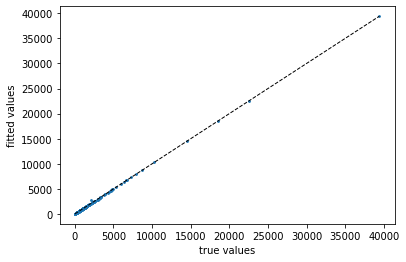

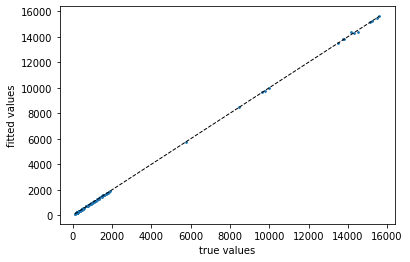

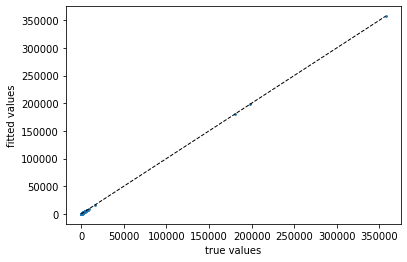

time period 1 predicted tweet:  137.87624578365794  true value:  120
time period 2 predicted tweet:  1235.8310336692448  true value:  1123
time period 3 predicted tweet:  76.7487146797494  true value:  87
time period 1 predicted tweet:  557.1288021345906  true value:  846
time period 2 predicted tweet:  864.855355760778  true value:  903
time period 3 predicted tweet:  44.13568662458161  true value:  46
time period 1 predicted tweet:  103.90749899643825  true value:  61
time period 2 predicted tweet:  27.402271656851138  true value:  28
time period 3 predicted tweet:  87.33949361248115  true value:  43


In [67]:
regs = train_lr(path, files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(path, file, regs)

## Random Forest Regressoion

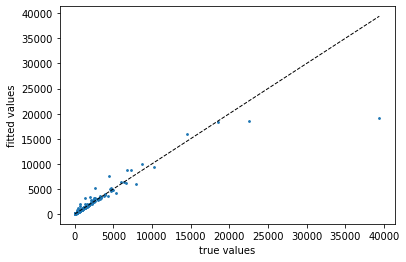

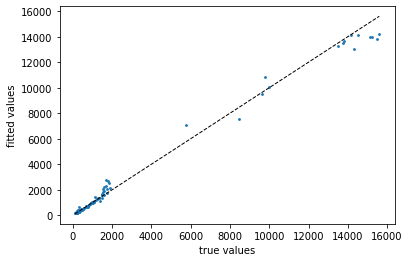

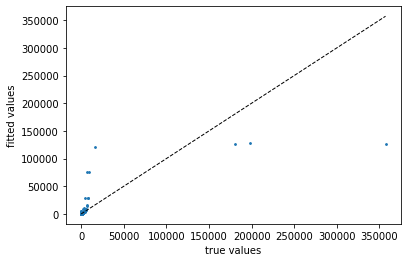

time period 1 predicted tweet:  190.53658458139734  true value:  120
time period 2 predicted tweet:  2390.3782428742516  true value:  1123
time period 3 predicted tweet:  1298.0577007008515  true value:  87
time period 1 predicted tweet:  572.613481553996  true value:  846
time period 2 predicted tweet:  3300.63721366327  true value:  903
time period 3 predicted tweet:  111.90663173264649  true value:  46
time period 1 predicted tweet:  175.9969439040168  true value:  61
time period 2 predicted tweet:  201.73803760940842  true value:  28
time period 3 predicted tweet:  185.32665935412624  true value:  43


In [70]:
regs = train_lr(path, files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(path, file, regs)

## Neural Network Regression

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


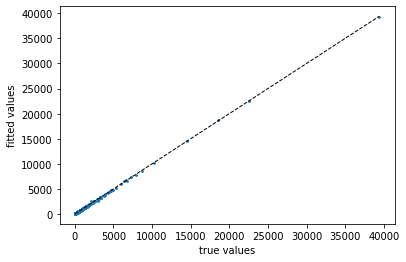

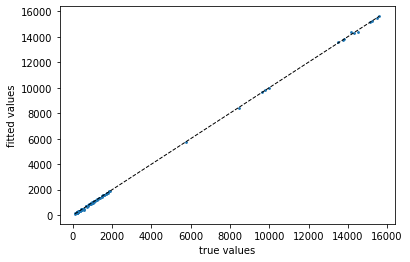

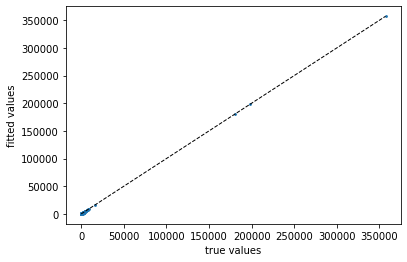

time period 1 predicted tweet:  732117721.7918141  true value:  120
time period 2 predicted tweet:  7916311863.260865  true value:  1123
time period 3 predicted tweet:  9683463354.026667  true value:  87
time period 1 predicted tweet:  1130647434.9352717  true value:  846
time period 2 predicted tweet:  4010775524.902999  true value:  903
time period 3 predicted tweet:  24509478439.240932  true value:  46
time period 1 predicted tweet:  621087252.0983255  true value:  61
time period 2 predicted tweet:  312884155.67408425  true value:  28
time period 3 predicted tweet:  25775071039.63326  true value:  43


In [73]:
regs = train_lr(path, files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(path, file, regs)

## Gradient Boosting Regression

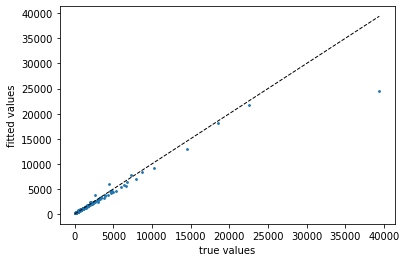

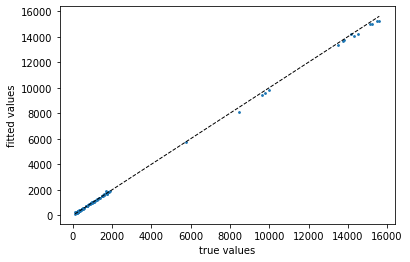

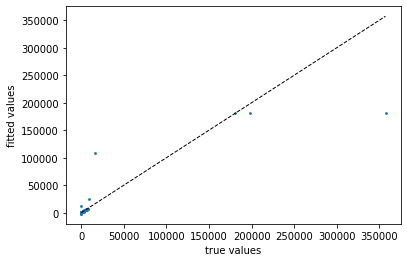

time period 1 predicted tweet:  296.70837197216116  true value:  120
time period 2 predicted tweet:  1781.4101380123634  true value:  1123
time period 3 predicted tweet:  -607.0834377004022  true value:  87
time period 1 predicted tweet:  676.0721928658722  true value:  846
time period 2 predicted tweet:  4547.882225545979  true value:  903
time period 3 predicted tweet:  620.6473456903806  true value:  46
time period 1 predicted tweet:  308.2108734032303  true value:  61
time period 2 predicted tweet:  106.80703539925454  true value:  28
time period 3 predicted tweet:  1498.1834987762527  true value:  43


In [75]:
regs = train_lr(path, files)
for file in test_files:
    (df_1,df_y_1,pred_y_1),(df_2,df_y_2,pred_y_2),(df_3,df_y_3,pred_y_3) = test_lr(path, file, regs)